# Realised Kernels in Practice: Trades and Quotes
## Jay Walke & Aman Arya

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

We consider the case where Y is a Brownian semimartingale plus Jump process ($\mathcal{BMSJ}$),

$$ Y_{t}=\int_{0}^{t} x_{u}\mathrm{d}u+\int_{0}^{t}\sigma_{u}\mathrm{d}W_{u}+J_{t} $$

where,  
  
$J_{t} = \sum_{i=1}^{N_{t}}C_{i} $ is a finite activity jump process  
$a$ is a predictable locally bounded drift  
$\sigma$ is a $c\grave{a}dl\grave{a}g$ volatility process  
$W$ is a Brownian motion  
  
Our object of interest in the quadratic variation of $Y$, 
$$ [Y]=\int_{0}^{T}\sigma_{u}^{2}\mathrm{d}u+\sum_{i=1}^{N_{T}}C_{i}^{2} $$

where,  
  
$ \textstyle\int_{0}^{T}\sigma_{u}^{2}du $ is the integrated variance. We estimate it from Observations,

$$ X_{\tau_{0}},...,X_{\tau_{n}},\ \ \ 0=\tau_{0}<\tau_{1}<\ldots<\tau_{n}=T $$
  
where $X_{\tau_{j}}$ is a noisy observation of $ Y_{\tau_{j}} $ i.e.

$$ X_{\tau_{j}} = Y_{\tau_{j}} + U_{\tau_{j}} $$

Our estimator takes the form,

$$ K(X)=\sum_{h=-H}^{H}k\left(\frac{h}{H+1}\right)\gamma_{h}, $$

where,  
$$ k(x)= \begin{cases}
    1-6x^{2} + 6x^{3} & 0 \leq x \leq 1/2 \\
    2(1-x)^{3} & 1/2 \leq x \leq 1\\
    0 & x > 1.
    \end{cases}$$
$$ \gamma_{h}=\sum_{j=|h|+1}^{h}X_{j}X_{j-|h|}, $$

In [4]:
# Loading Data
# path_trades = "D:\\Practice\\Python\\TAQ-Query-Scripts-Public\\data\\trades_AA_20200801-20200805.csv"
path_trades = "/Users/amanarya/sem_1/AMS-520/my_data/trades_AA_20200801-20200805.csv"
raw_trade_data = pd.read_csv(path_trades, usecols=['Time', 'Exchange','Trade_Price','Trade_Correction_Indicator'])
raw_trade_data['Time'] = pd.to_datetime(raw_trade_data['Time'],format="%Y-%m-%d %H:%M:%S.%f")
raw_trade_data.set_index('Time',inplace=True)
l = len(raw_trade_data)
print(f'Total number of Rows: {l}')
raw_trade_data.head(10)
df=raw_trade_data

Total number of Rows: 56978


In [5]:
df['Exchange'].value_counts()

Exchange
D    15076
T    11473
Z     5530
P     5374
K     5232
N     4785
J     2355
C     2045
Y     1854
V     1789
B      722
X      525
A      217
M        1
Name: count, dtype: int64

In [8]:
# df['Symbol'].value_counts()
df.columns

Index(['Exchange', 'Trade_Price', 'Trade_Correction_Indicator'], dtype='object')

In [6]:
raw_trade_data = raw_trade_data[raw_trade_data['Exchange'] == 'N']
print(f'Total Rows removed: {l-len(raw_trade_data)}')
print(f'Total no. of Rows: {len(raw_trade_data)}')
l = len(raw_trade_data)
raw_trade_data.head(10)

Total Rows removed: 52193
Total no. of Rows: 4785


,Exchange,Trade_Price,Trade_Correction_Indicator
Time,,,
2020-08-03 09:30:00.788503,N,13.08,0
2020-08-03 09:30:00.788503,N,13.08,0
2020-08-03 09:30:04.785706,N,13.05,0
2020-08-03 09:30:11.006512,N,13.02,0
2020-08-03 09:30:11.007406,N,13.00,0
2020-08-03 09:30:11.007559,N,13.00,0
2020-08-03 09:30:11.007639,N,13.00,0
2020-08-03 09:30:15.100344,N,13.01,0
2020-08-03 09:30:20.583388,N,13.01,0


In [7]:
# Filters
raw_trade_data = raw_trade_data.between_time('9:30', '16:00')
print(f'Total no. of Rows: {len(raw_trade_data)}')
print(f'Total rows removed: {l-len(raw_trade_data)}')
l = len(raw_trade_data)

Total no. of Rows: 4769
Total rows removed: 16


In [8]:
raw_trade_data = raw_trade_data[raw_trade_data['Trade_Correction_Indicator'] == 0]
print(f'Length of Data after P1 filter: {len(raw_trade_data)}')
print(f'Total rows removed: {l-len(raw_trade_data)}')
l = len(raw_trade_data)

Length of Data after P1 filter: 4769
Total rows removed: 0


In [9]:
raw_trade_data
trade_data = raw_trade_data[['Trade_Price']].copy()
trade_data_filtered = trade_data.groupby(trade_data.index).median()
print(f'Final no. of rows: {len(trade_data_filtered)}')
print(f'Rows removed: {l-len(trade_data_filtered)}')
trade_data_filtered.tail()

Final no. of rows: 4680
Rows removed: 89


,Trade_Price
Time,
2020-08-04 15:59:58.144610,13.66
2020-08-04 15:59:58.650451,13.67
2020-08-04 15:59:58.699221,13.67
2020-08-04 15:59:58.700078,13.67
2020-08-04 15:59:58.897863,13.67


In [10]:
data = []
for date in sorted(list(set(trade_data.index.date))):
    data.append(trade_data[trade_data.index.date == date])

<Axes: xlabel='Time', ylabel='Price'>

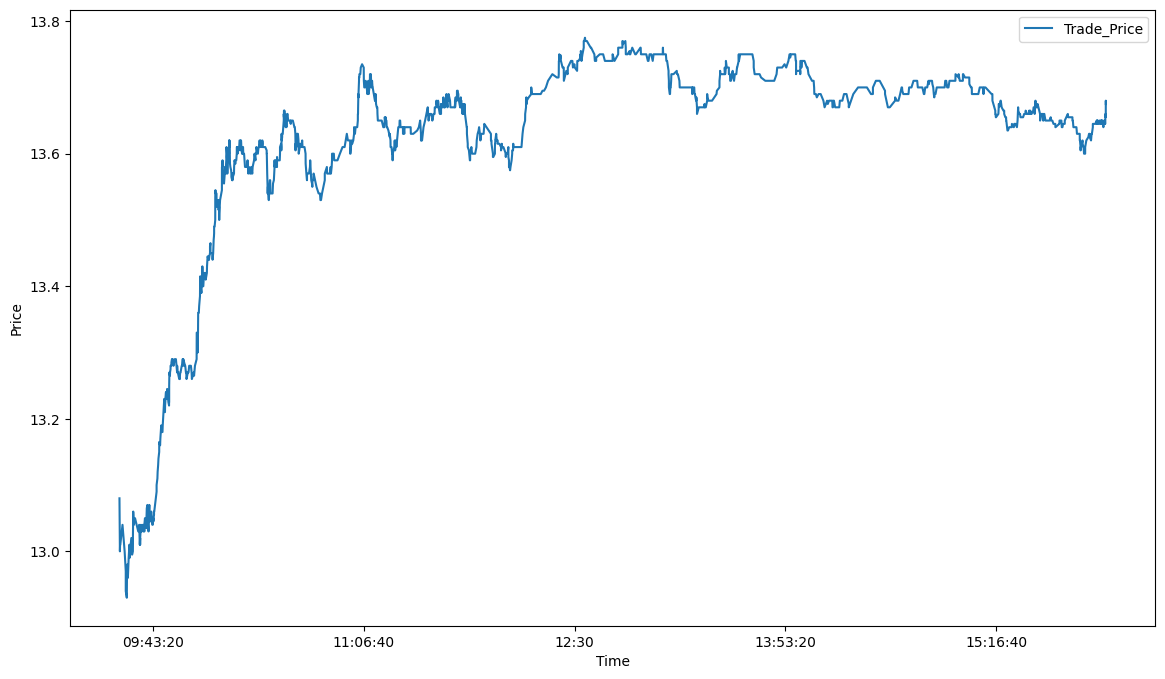

In [11]:
df = data[0].copy()
df['Time'] = df.index.time
# plt.figure(figsize=(10,8))
# plt.plot(df.index.time, df['Trade_Price'],'bo',markersize = 1)
df.plot(x='Time',y='Trade_Price',figsize = (14,8),ylabel = 'Price')

In [12]:
class Data:
    def __init__(self, trade_dir, quote_dir):
        self.raw_trades = pd.read_csv(trade_dir)
        # self.raw_quotes = pd.read_csv(quote_dir)

        self.raw_trade_data = self.raw_trades.copy()
        # self.raw_quote_data = self.raw_quotes.copy()

        self.filtered_trade_data = None
        self.filtered_quote_data = None
        self.trade_transaction_prices = None

    
    def get_filtered_trade_data(self):
        # Filters
        self.raw_trade_data['Time'] = pd.to_datetime(self.raw_trade_data['Time'],format="%Y-%m-%d %H:%M:%S.%f")
        self.raw_trade_data.set_index('Time',inplace=True)
        self.raw_trade_data.head(10)
        self.raw_trade_data = self.raw_trade_data.between_time('9:30', '16:00')
        self.raw_trade_data = self.raw_trade_data[self.raw_trade_data['Trade_Correction_Indicator'] == 0]
        self.raw_trade_data = self.raw_trade_data[self.raw_trade_data['Exchange'] == 'N']
        trade_data = self.raw_trade_data[['Trade_Price']].copy()
        self.filtered_trade_data = (trade_data.groupby(trade_data.index).median())
        self.trade_transaction_prices = self.filtered_trade_data.to_numpy()
        return self.filtered_trade_data, self.filtered_quote_data


In [15]:
filtered_trade_data = Data(path_trades,None).get_filtered_trade_data()

In [16]:
from realised_kernels import RealisedKernel

In [18]:
RealisedKernel(path_trades,None).KernelEstimator()

Kernel Estimate: 0.01069274999999997
